In [2]:
import random
import itertools

import torch
import torch.nn as nn
from cmws import util
import torch
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    HardPhongShader,
    TexturesUV,
    TexturesVertex,
    BlendParams,
    softmax_rgb_blend
)
from pytorch3d.structures.meshes import (
    Meshes,
    join_meshes_as_batch,
    join_meshes_as_scene,
)
import numpy as np
from cmws.examples.scene_understanding import data, render
from cmws import util
import matplotlib.pyplot as plt

device = 'cpu'

In [3]:
import pyro

def sample_stacking_program(num_primitives, device, address_suffix="", fixed_num_blocks=False):
    """Samples blocks to stack from a set [0, ..., num_primitives - 1]
    *without* replacement. The number of blocks is stochastic and
    can be < num_primitives.

    Args
        num_primitives (int)
        device
        address_suffix

    Returns [num_blocks] (where num_blocks is stochastic and between 1 and num_primitives
        (inclusive))
    """

    # Init
    stacking_program = []
    available_primitive_ids = list(range(num_primitives))

    if fixed_num_blocks:
        num_blocks = num_primitives
    else:
        # Sample num_blocks uniformly from [1, ..., num_primitives] (inclusive)
        raw_num_blocks_logits = torch.ones((num_primitives,), device=device)
        raw_num_blocks = pyro.sample(
            f"raw_num_blocks{address_suffix}",
            pyro.distributions.Categorical(logits=raw_num_blocks_logits),
        )
        num_blocks = raw_num_blocks + 1

    # Sample primitive ids
    for block_id in range(num_blocks):
        # Sample primitive
        raw_primitive_id_logits = torch.ones((len(available_primitive_ids),), device=device)
        raw_primitive_id = pyro.sample(
            f"raw_primitive_id_{block_id}{address_suffix}",
            pyro.distributions.Categorical(logits=raw_primitive_id_logits),
        )
        primitive_id = available_primitive_ids.pop(raw_primitive_id)

        # Add to the stacking program based on previous action
        stacking_program.append(primitive_id)

    return torch.tensor(stacking_program, device=device)

def sample_raw_locations(stacking_program, address_suffix=""):
    """
    Samples the (raw) horizontal location of blocks in the stacking program.
    p(raw_locations | stacking_program)

    Args
        stacking_program [num_blocks]

    Returns [num_blocks]
    """
    device = stacking_program[0].device
    dist = pyro.distributions.Independent(
        pyro.distributions.Normal(torch.zeros((len(stacking_program),), device=device), 1),
        reinterpreted_batch_ndims=1,
    )
    return pyro.sample(f"raw_locations{address_suffix}", dist)

In [4]:
primitives = [
    render.Block(
        "A",
        torch.tensor([1.0, 0.0, 0.0], device=device),
        torch.tensor([0.3, 0.3, 0.3], device=device),
    ),
    render.Block(
        "B",
        torch.tensor([0.0, 1.0, 0.0], device=device),
        torch.tensor([0.4, 0.4, 0.4], device=device),
    ),
    render.Block(
        "C",
        torch.tensor([0.0, 0.0, 1.0], device=device),
        torch.tensor([0.5, 0.5, 0.5], device=device),
    ),
    render.Block(
        "D",
        torch.tensor([1.0, 0.0, 0.0], device=device),
        torch.tensor([0.5, 0.3, 0.3], device=device),
    ),
    render.Block(
        "E",
        torch.tensor([1.0, 0.0, 0.0], device=device),
        torch.tensor([0.3, 0.5, 0.3], device=device),
    ),
    render.Block(
        "F",
        torch.tensor([1.0, 0.0, 0.0], device=device),
        torch.tensor([0.3, 0.3, 0.5], device=device),
    ),
]

num_primitives = len(primitives)

SIZES:  torch.Size([1, 4, 5, 3])
img:  torch.Size([3, 256, 256])


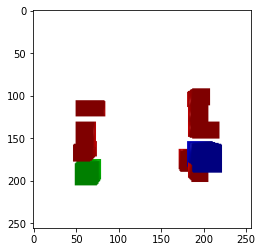

In [10]:
# Determine which cells have stacks
import cv2 
num_grid_rows = 2
num_grid_cols = 2
max_num_blocks = 5
im_size = 256
remove_color = False
mode ="block"
shrink_factor=0.01

cells = list(itertools.product(range(num_grid_rows), range(num_grid_cols)))
num_cells = num_grid_rows * num_grid_cols
num_stacks = random.randint(1, num_cells)
cells_with_stack = set(random.sample(cells, num_stacks))

# Sample
num_blocks = []
stacking_program = []
raw_locations = []
for row in range(num_grid_rows):
    for col in range(num_grid_cols):
        if (row, col) in cells_with_stack:
            num_blocks_ = random.randint(1, max_num_blocks)
            stacking_program_ = torch.randint(0, num_primitives, [num_blocks_], device=device)
            raw_locations_ = torch.randn(num_blocks_, device=device)
            num_blocks.append(num_blocks_)
            stacking_program_padded = torch.zeros(max_num_blocks, device=device).long()
            stacking_program_padded[: num_blocks[-1]] = stacking_program_
            raw_locations_padded = torch.zeros(max_num_blocks, device=device)
            raw_locations_padded[: num_blocks[-1]] = raw_locations_
            stacking_program.append(stacking_program_padded)
            raw_locations.append(raw_locations_padded)
        else:
            num_blocks.append(0)
            stacking_program.append(torch.zeros(max_num_blocks, device=device).long())
            raw_locations.append(torch.zeros(max_num_blocks, device=device))
num_blocks = torch.tensor(num_blocks, device=device).long().view(num_grid_rows, num_grid_cols)
stacking_program = torch.stack(stacking_program).view(
    num_grid_rows, num_grid_rows, max_num_blocks
)
raw_locations = torch.stack(raw_locations).view(num_grid_rows, num_grid_rows, max_num_blocks)

# Render
img = render.render(
    primitives, num_blocks, stacking_program, raw_locations, im_size, remove_color=remove_color, mode=mode,
    shrink_factor=shrink_factor
)
print("img: ", img.shape)
img = img.permute(1,2,0)
plt.imshow(img)
#plt.axis('off')

In [ ]:
raw_locations

In [ ]:
im_size = 32

shape = stacking_program.shape[:-1]
max_num_blocks = stacking_program.shape[-1]
num_elements = util.get_num_elements(shape)
num_channels = 3
num_blocks = torch.tensor(len(stacking_program), device=device).long()

# [num_primitives]
square_size = torch.stack([primitive.size for primitive in primitives])
# [num_primitives, 3]
square_color = torch.stack([primitive.color for primitive in primitives])

# Convert [*shape, max_num_blocks, 3]
locations = render.convert_raw_locations_batched(raw_locations, stacking_program, primitives)

# Flatten
num_blocks_flattened = num_blocks.reshape(num_elements)
stacking_program_flattened = stacking_program.reshape((num_elements, max_num_blocks))
locations_flattened = locations.view((num_elements, max_num_blocks, 3))

imgs = render.render_cubes(num_blocks_flattened, square_size[stacking_program_flattened], square_color[stacking_program_flattened], locations_flattened, im_size)
imgs = imgs.permute(0, 3, 1, 2)
imgs = imgs.view(*[*shape, num_channels, *imgs.shape[-2:]])

In [ ]:
num_cubes = num_blocks_flattened
sizes = square_size[stacking_program_flattened]
colors = square_color[stacking_program_flattened]
positions = locations_flattened

In [ ]:

im_size = 512

# Create camera
R, T = look_at_view_transform(1.0, 90, 180,
                              up=((0.0, -1.0, 0.0),),
                              at=((0.0, 1, -0.2),))  # view top to see stacking
cameras = FoVPerspectiveCameras(device=device, R=R, T=T,
                               fov=60.0)

# Settings for rasterizer (optional blur)
# 
blend_params = BlendParams( sigma = 1e-4, gamma = 1e-4,background_color=(0.0,0.0,0.0))
raster_settings = RasterizationSettings(
    image_size=im_size, # crisper objects + texture w/ higher resolution
    blur_radius = np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=2, # increase at cost of GPU memory,
    bin_size=0
)

# Add light from the front
lights = PointLights(device=device, location=[[0.0, 3.0, 0.0]]) # top light

# Compose renderer and shader
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights,
        blend_params=blend_params
    )
)

# create one mesh per elmt in batch

meshes = []
for batch_idx, n_cubes in enumerate(num_cubes):
    # Combine obj meshes into single mesh from rendering
    # https://github.com/facebookresearch/pytorch3d/issues/15
    vertices = []
    faces = []
    textures = []
    vert_offset = 0 # offset by vertices from prior meshes
    for i, (position, size,color) in enumerate(zip(positions[batch_idx, :n_cubes, :], sizes[batch_idx, :n_cubes],
                                                   colors[batch_idx, :n_cubes, :])):
        cube_vertices, cube_faces = render.get_cube_mesh(position, size)
        # For now, apply same color to each mesh vertex (v \in V)
        texture = torch.ones_like(cube_vertices) * color# [V, 3]
        # Offset faces (account for diff indexing, b/c treating as one mesh)
        cube_faces = cube_faces + vert_offset
        vert_offset = cube_vertices.shape[0]
        vertices.append(cube_vertices)
        faces.append(cube_faces)
        textures.append(texture)

    # Concatenate data into single mesh
    vertices = torch.cat(vertices)
    faces = torch.cat(faces)
    textures = torch.cat(textures)[None]  # (1, num_verts, 3)
    textures = TexturesVertex(verts_features=textures)
    # each elmt of verts array is diff mesh in batch
    mesh = Meshes(verts=[vertices], faces=[faces], textures=textures)
    meshes.append(mesh)

batched_mesh = join_meshes_as_batch(meshes)

# Render image
img = renderer(batched_mesh)   # (B, H, W, 4)

# Remove alpha channel and return (B, im_size, im_size, 3)
img = img[:, ..., :3]#.detach().squeeze().cpu().numpy()

In [ ]:
plt.imshow(img[0])
#plt.axis('off')

In [ ]:
plt.imshow(img[0])
#plt.axis('off')

In [ ]:
from itertools import tee
from math import cos, pi, sin
from typing import Iterator, Optional, Tuple

import torch
from pytorch3d.structures.meshes import Meshes


# Make an iterator over the adjacent pairs: (-1, 0), (0, 1), ..., (N - 2, N - 1)
def _make_pair_range(N: int) -> Iterator[Tuple[int, int]]:
    i, j = tee(range(-1, N))
    next(j, None)
    return zip(i, j)
r = 0.10
R = 0.7
sides = 100
rings = 5

verts = []
for i in range(rings):
    # phi ranges from 0 to 2 pi (rings - 1) / rings
    phi = 2 * pi * i / rings
    for j in range(sides):
        # theta ranges from 0 to 2 pi (sides - 1) / sides
        theta = 2 * pi * j / sides
        x = (R + r * cos(theta)) * cos(phi)
        y = (R + r * cos(theta)) * sin(phi)
        z = r * sin(theta)
        # This vertex has index i * sides + j
        verts.append([x, y, z])

faces = []
for i0, i1 in _make_pair_range(rings):
    index0 = (i0 % rings) * sides
    index1 = (i1 % rings) * sides
    for j0, j1 in _make_pair_range(sides):
        index00 = index0 + (j0 % sides)
        index01 = index0 + (j1 % sides)
        index10 = index1 + (j0 % sides)
        index11 = index1 + (j1 % sides)
        faces.append([index00, index10, index11])
        faces.append([index11, index01, index00])

verts_list = [torch.tensor(verts, dtype=torch.float32, device=device)]
faces_list = [torch.tensor(faces, dtype=torch.int64, device=device)]

textures = torch.ones_like(torch.tensor(verts, dtype=torch.float32, device=device)) * color# [V, 3]
textures = textures[None]
textures = TexturesVertex(verts_features=textures)
# each elmt of verts array is diff mesh in batch
mesh = Meshes(verts=verts_list, faces=faces_list, textures=textures)

In [ ]:
img = renderer(mesh)   # (B, H, W, 4)
# Remove alpha channel and return (B, im_size, im_size, 3)
img = img[:, ..., :3]#.detach().squeeze().cpu().numpy()
plt.imshow(img[0])
#plt.axis('off')

In [ ]:
# Make an iterator over the adjacent pairs: (-1, 0), (0, 1), ..., (N - 2, N - 1)
def _make_pair_range(N: int, start=-1) -> Iterator[Tuple[int, int]]:
    i, j = tee(range(start, N))
    next(j, None)
    return zip(i, j)

radius = 0.15
height = 0.5
closed = True
sides = 100
rings = 5

if not (sides > 0):
    raise ValueError("sides must be > 0.")
if not (rings > 0):
    raise ValueError("rings must be > 0.")
device = "cpu"#device if device else torch.device("cpu")

verts = []
for h in range(rings):
    z = height * h/(rings-1) - height/2
    for i in range(sides):
        # theta ranges from 0 to 2 pi (sides - 1) / sides
        theta = 2 * pi * i / sides
        x = radius * cos(theta)
        y = radius * sin(theta)
        verts.append([x, y, z])
if closed:
    # bottom center
    verts.append([0, 0, -height/2])
    #top center
    verts.append([0, 0, height/2])

faces = []
for i0, i1 in _make_pair_range(sides):
    index0 = i0 % sides
    index1 = i1 % sides
    for j in range(rings-1):
        index00 = index0 + (j * sides)
        index01 = index0 + ((j+1) *sides)
        index10 = index1 + (j * sides)
        index11 = index1 + ((j+1) *sides)
        faces.append([index00, index10, index11])
        faces.append([index11, index01, index00])

if closed:
    # close bottom and top of cylinder
    for i0, i1 in _make_pair_range(sides):
        index0 = i0 % sides
        index1 = i1 % sides
        faces.append([index0, len(verts)-2, index1])
        faces.append([index1 + (rings-1)*sides, len(verts)-1, index0 + (rings-1)*sides])

verts_list = [torch.tensor(verts, dtype=torch.float32, device=device)]
faces_list = [torch.tensor(faces, dtype=torch.int64, device=device)]

textures = torch.ones_like(torch.tensor(verts, dtype=torch.float32, device=device)) * color# [V, 3]
textures = textures[None]
textures = TexturesVertex(verts_features=textures)
# each elmt of verts array is diff mesh in batch
mesh = Meshes(verts=verts_list, faces=faces_list, textures=textures)

img = renderer(mesh)   # (B, H, W, 4)
# Remove alpha channel and return (B, im_size, im_size, 3)
img = img[:, ..., :3]#.detach().squeeze().cpu().numpy()
plt.imshow(img[0])

In [ ]:
height=1.0
radius=1.0
count=[32, 32]
"""
Create a mesh of a capsule, or a cylinder with hemispheric ends.
Parameters
----------
height : float
Center to center distance of two spheres
radius : float
Radius of the cylinder and hemispheres
count : (2,) int
Number of sections on latitude and longitude
Returns
----------
capsule : trimesh.Trimesh
Capsule geometry with:
- cylinder axis is along Z
- one hemisphere is centered at the origin
- other hemisphere is centered along the Z axis at height
"""
height = float(height)
radius = float(radius)
count = np.array(count, dtype=np.int64)
count += np.mod(count, 2)

tol_merge = 1e-5
tol_zero = 1e-12

# create a theta where there is a double band around the equator
# so that we can offset the top and bottom of a sphere to
# get a nicely meshed capsule
theta = np.linspace(0, np.pi, count[0])
center = np.clip(np.arctan(tol_merge / radius),
         tol_merge, np.inf)
offset = np.array([-center, center]) + (np.pi / 2)
theta = np.insert(theta,
          int(len(theta) / 2),
          offset)

capsule = uv_sphere(radius=radius,
            count=count,
            theta=theta)

top = capsule.vertices[:, 2] > tol_zero
capsule.vertices[top] += [0, 0, height]
capsule.metadata.update({'shape': 'capsule',
                 'height': height,
                 'radius': radius})

In [ ]:
im_size = 256

# Create camera
R, T = look_at_view_transform(1.0, 90, 180,
                              up=((0.0, -1.0, 0.0),),
                              at=((0.0, 1, -0.2),))  # view top to see stacking
cameras = FoVPerspectiveCameras(device=device, R=R, T=T,
                               fov=60.0)

# Settings for rasterizer (optional blur)
# 
blend_params = BlendParams( sigma = 1e-4, gamma = 1e-4)#,background_color=(0.0,0.0,0.0))
raster_settings = RasterizationSettings(
    image_size=im_size, # crisper objects + texture w/ higher resolution
    blur_radius = np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=2, # increase at cost of GPU memory,
    bin_size=0
)

# Add light from the front
lights = PointLights(device=device, location=[[0.0, 3.0, 0.0]]) # top light

# Compose renderer and shader
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights,
        blend_params=blend_params
    )
)

In [ ]:
position = position
size = sizes[batch_idx, :n_cubes][0]

# hardcoded face indices
faces = torch.tensor(
    [
        1,
        3,
        0,
        4,
        1,
        0,
        0,
        3,
        2,
        2,
        4,
        0,
        1,
        7,
        3,
        5,
        1,
        4,
        5,
        7,
        1,
        3,
        7,
        2,
        6,
        4,
        2,
        2,
        7,
        6,
        6,
        5,
        4,
        7,
        5,
        6,
    ],
    dtype=torch.int32,
    device=device,
).view(-1, 3)


# vertices of the cube
centered_vertices = (
    torch.tensor(
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1],
        dtype=torch.float,
        device=device,
    ).view(-1, 3)
    - 0.5
)
size = torch.tensor([0.7, 0.5, 1.0])
translation = position.clone()
print("translation: ", translation)
#translation[-1] += size[1] / 2
print("translation: ", translation, " size: ", size)
vertices = centered_vertices * size + translation[None]
cube_vertices = vertices
cube_faces = faces

In [ ]:
meshes = []
for batch_idx, n_cubes in enumerate(num_cubes):
    # Combine obj meshes into single mesh from rendering
    # https://github.com/facebookresearch/pytorch3d/issues/15
    vertices = []
    faces = []
    textures = []
    vert_offset = 0 # offset by vertices from prior meshes
    
    #cube_vertices, cube_faces = render.get_cube_mesh(position, size)
    # For now, apply same color to each mesh vertex (v \in V)
    texture = torch.ones_like(cube_vertices) * color# [V, 3]
    # Offset faces (account for diff indexing, b/c treating as one mesh)
    cube_faces = cube_faces + vert_offset
    vert_offset = cube_vertices.shape[0]
    vertices.append(cube_vertices)
    faces.append(cube_faces)
    textures.append(texture)

    # Concatenate data into single mesh
    vertices = torch.cat(vertices)
    faces = torch.cat(faces)
    textures = torch.cat(textures)[None]  # (1, num_verts, 3)
    textures = TexturesVertex(verts_features=textures)
    # each elmt of verts array is diff mesh in batch
    mesh = Meshes(verts=[vertices], faces=[faces], textures=textures)
    meshes.append(mesh)

batched_mesh = join_meshes_as_batch(meshes)

# Render image
img = renderer(batched_mesh)   # (B, H, W, 4)

# Remove alpha channel and return (B, im_size, im_size, 3)
img = img[:, ..., :3]#.detach().squeeze().cpu().numpy()

plt.imshow(img[0])

In [ ]:
sizes[batch_idx, :n_cubes][0]